In [44]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.interpolate import interp1d

In [45]:

def slide_func(data, window_size, iter):
    if iter >= window_size:
        if iter % (1 * 512) == 0:
            sliding_window_start = iter - window_size
            sliding_window_end = iter
            sliding_window = np.array(data[sliding_window_start:sliding_window_end])  # sliding_window ~ y
            return sliding_window
        return None
    return None

def filter_data(data):
    # Bandpass filter
    band = [0.5 / (0.5 * 512), 40 / (0.5 * 512)]
    b, a = sp.signal.butter(4, band, btype='band', analog=False, output='ba')
    data = sp.signal.lfilter(b, a, data)

    # Filter for EMG by interpolated
    filtered_data = data[(np.abs(data) <= 256)]
    x = np.arange(len(filtered_data))
    interpolated_data = interp1d(x, filtered_data)(np.linspace(0, len(filtered_data) - 1, len(data)))
    return interpolated_data

def hjorth_parameters(signal):
    diff1 = np.diff(signal) # Tính đạo hàm bậc nhất
    diff2 = np.diff(diff1)  # Tính đạo hàm bậc hai

    activity = np.var(signal)      # Activity (A)
    mobility = np.sqrt(np.var(diff1) / activity)  # Mobility (B)
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) / mobility  # Complexity (C)

    return activity, mobility, complexity

def FeatureExtract(data, number):
    f, t, Zxx = sp.signal.stft(data, 512, nperseg=15 * 512, noverlap=14 * 512)
    delta = np.array([], dtype=float)
    theta = np.array([], dtype=float)
    alpha = np.array([], dtype=float)
    beta = np.array([], dtype=float)

    for i in range(0, int(t[-1])):
        indices = np.where((f >= 0.5) & (f <= 4))[0]
        delta = np.append(delta, np.sum(np.abs(Zxx[indices, i])))

        indices = np.where((f >= 4) & (f <= 8))[0]
        theta = np.append(theta, np.sum(np.abs(Zxx[indices, i])))

        indices = np.where((f >= 8) & (f <= 13))[0]
        alpha = np.append(alpha, np.sum(np.abs(Zxx[indices, i])))

        indices = np.where((f >= 13) & (f <= 30))[0]
        beta = np.append(beta, np.sum(np.abs(Zxx[indices, i])))

    abr = alpha / beta
    tbr = theta / beta
    dbr = delta / beta
    tar = theta / alpha
    dar = delta / alpha
    dtabr = (alpha + beta) / (delta + theta)

    diction = {
        "delta": delta,
        "theta": theta,
        "alpha": alpha,
        "beta": beta,
        "abr": abr,
        "tbr": tbr,
        "dbr": dbr,
        "tar": tar,
        "dar": dar,
        "dtabr": dtabr,
        "emotion": number
    }

    return diction

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)



In [47]:
import os
folder_path = '../CollectedData/new_data'

buon_data = []
vui_data = []
calm_data = []

for filename in os.listdir(folder_path):
    # Kiểm tra nếu là file .txt
    if filename.endswith(".txt"):
        # Đọc dữ liệu từ file
        file_data = np.loadtxt(os.path.join(folder_path, filename))
        # Xác định trạng thái tinh thần và thêm vào mảng tương ứng
        if "Buon" in filename and filename != "QuangBuon.txt":
            buon_data.append(file_data)
            # print(filename)
        elif "Vui" in filename:
            vui_data.append(file_data)
            print(filename)
        elif "Calm" in filename:
            calm_data.append(file_data)
            # print(filename)
        
buon_data = np.concatenate(buon_data, axis=0)
vui_data = np.concatenate(vui_data, axis=0)
calm_data = np.concatenate(calm_data, axis=0)

print("Sad data:", buon_data.shape)
print("Happy data:", vui_data.shape)
print("Calm data:", calm_data.shape)


ThaiVui2.txt
SonVui4.txt
ThanhfVui2.txt
ThaiVui.txt
QuangVui3.txt
ThanhfVui.txt
Sad data: (307200,)
Happy data: (368640,)
Calm data: (368640,)


In [107]:
Sad = filter_data(buon_data)
Happy = filter_data(vui_data)
Calm = filter_data(calm_data)

# Extract features
features = FeatureExtract(Sad, 0)
features2 = FeatureExtract(Happy, 2)
features3 = FeatureExtract(Calm, 1)

# Save features to CSV
save_to_csv(features, 'Sad.csv')
save_to_csv(features2, 'Happy.csv')
save_to_csv(features3, 'Calm.csv')

print("EEG features saved to csv")

EEG features saved to csv


In [108]:
Sad = pd.read_csv('Sad.csv')
Calm = pd.read_csv('Calm.csv')
Happy = pd.read_csv('Happy.csv')

print("Sad_preprocess data:", Sad.shape)
print("Calm_preprocess data:", Calm.shape)
print("Happy_preprocess data:", Happy.shape)


Sad_preprocess data: (600, 11)
Calm_preprocess data: (720, 11)
Happy_preprocess data: (720, 11)


In [109]:
Sad

,delta,theta,alpha,beta,abr,tbr,dbr,tar,dar,dtabr,emotion
0,108.015600,45.585090,35.336996,122.037309,0.289559,0.373534,0.885103,1.290010,3.056728,1.024568,0
1,131.157697,54.820807,40.515608,141.327210,0.286679,0.387900,0.928043,1.353079,3.237214,0.977763,0
2,146.040149,61.526698,44.460825,156.625939,0.283866,0.392826,0.932414,1.383841,3.284693,0.968781,0
3,150.324018,65.303218,47.641917,168.306087,0.283067,0.388003,0.893159,1.370709,3.155289,1.001488,0
4,144.455664,66.094740,50.492971,177.074079,0.285152,0.373260,0.815792,1.308989,2.860906,1.080820,0
...,...,...,...,...,...,...,...,...,...,...,...
595,73.342972,51.387242,45.872376,227.066370,0.202022,0.226309,0.323002,1.120222,1.598848,2.188233,0
596,67.039255,51.633928,47.283214,220.742140,0.214201,0.233911,0.303699,1.092014,1.417824,2.258517,0
597,59.332496,51.040429,47.774574,213.175477,0.224109,0.239429,0.278327,1.068360,1.241926,2.364258,0
598,50.999481,49.245113,46.498301,202.267844,0.229885,0.243465,0.252138,1.059073,1.096803,2.481592,0


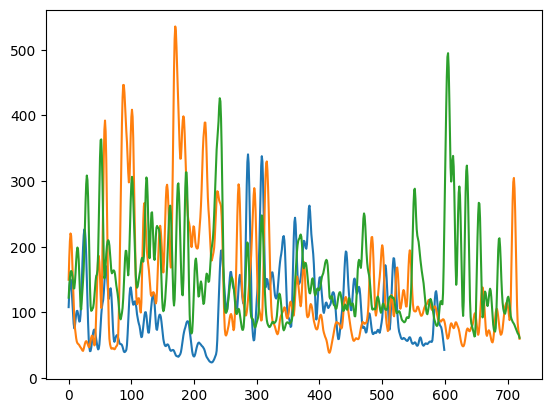

In [110]:
import matplotlib.pyplot as plt
plt.plot(Sad['delta'])
plt.plot(Calm['delta'])
plt.plot(Happy['delta'])
plt.show()

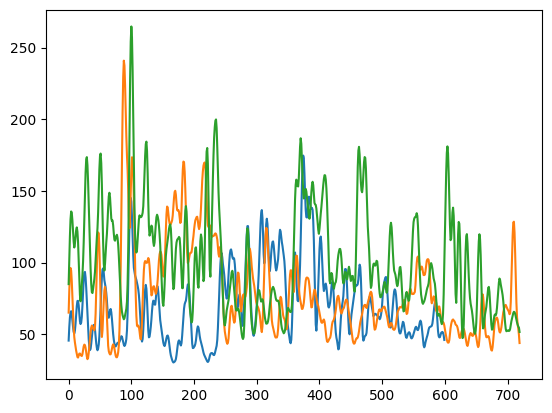

In [111]:

plt.plot(Sad['theta'])
plt.plot(Calm['theta'])
plt.plot(Happy['theta'])
plt.show()

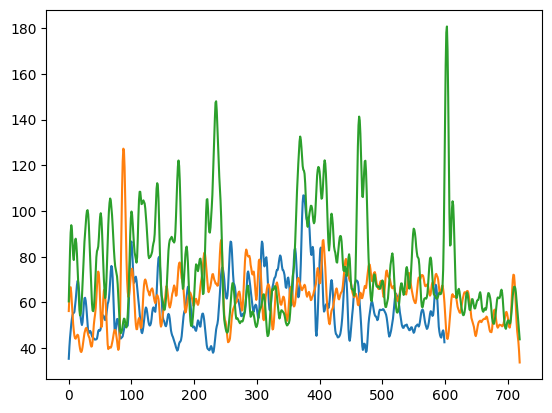

In [112]:

plt.plot(Sad['alpha'])
plt.plot(Calm['alpha'])
plt.plot(Happy['alpha'])
plt.show()

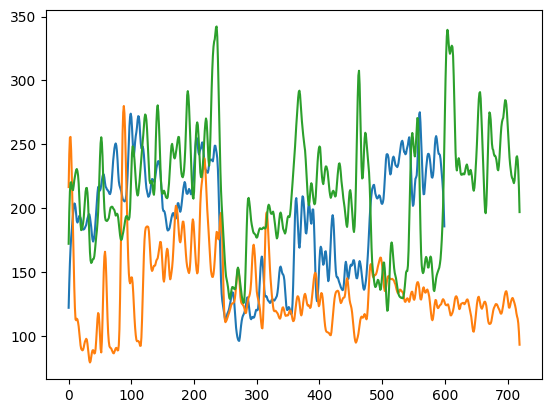

In [113]:

plt.plot(Sad['beta'])
plt.plot(Calm['beta'])
plt.plot(Happy['beta'])
plt.show()

In [114]:
def df_to_X_y(df, window_size=30):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a[:-1]] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][-1]
    y.append(label)
  return np.array(X), np.array(y)
feature_VUI, label_VUI = df_to_X_y(Happy)
feature_BUON, label_BUON = df_to_X_y(Sad)
feature_CALM, label_CALM = df_to_X_y(Calm)

feature_VUI = np.squeeze(feature_VUI)
feature_BUON = np.squeeze(feature_BUON)
feature_CALM = np.squeeze(feature_CALM)


In [115]:
print(feature_VUI[1])


[[1.39875021e+02 1.02668521e+02 7.20758844e+01 1.97051432e+02
  3.65771938e-01 5.21023977e-01 7.09840162e-01 1.42445038e+00
  1.94066326e+00 1.10960414e+00]
 [1.52998193e+02 1.18044862e+02 8.24805463e+01 2.12815909e+02
  3.87567578e-01 5.54680628e-01 7.18922725e-01 1.43118429e+00
  1.85496095e+00 1.08948173e+00]
 [1.61088478e+02 1.30206664e+02 9.04659644e+01 2.19876273e+02
  4.11440320e-01 5.92181511e-01 7.32632382e-01 1.43928896e+00
  1.78065286e+00 1.06538762e+00]
 [1.63110371e+02 1.35676037e+02 9.38000132e+01 2.20371600e+02
  4.25644743e-01 6.15669337e-01 7.40160576e-01 1.44643942e+00
  1.73891629e+00 1.05149232e+00]
 [1.61461752e+02 1.34694999e+02 9.20167471e+01 2.17121653e+02
  4.23802720e-01 6.20366497e-01 7.43646474e-01 1.46380962e+00
  1.75469963e+00 1.04383371e+00]
 [1.54886071e+02 1.29349515e+02 8.65377372e+01 2.14765752e+02
  4.02940116e-01 6.02281852e-01 7.21186079e-01 1.49471802e+00
  1.78980958e+00 1.06004844e+00]
 [1.45509472e+02 1.21849766e+02 8.04315294e+01 2.14121657e

In [116]:
features = np.vstack((feature_VUI, feature_BUON, feature_CALM))
labels = np.concatenate((label_VUI, label_BUON, label_CALM))
print(features.shape)
print(labels.shape)

(1950, 30, 10)
(1950,)


In [117]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from keras.models import Sequential, Model
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, MultiHeadAttention, Input, DepthwiseConv2D, LSTM, Bidirectional,Embedding, Input,GlobalAveragePooling2D,GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, GRU
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)

batch_size = 32
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
data_train = data_train.repeat(10).batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size=500)
data_test = data_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

print(X_train[1])

2.16.1
[[1.31620922e+02 7.94688990e+01 6.30731171e+01 2.75024957e+02
  2.29335976e-01 2.88951591e-01 4.78578102e-01 1.25994881e+00
  2.08679907e+00 1.60167872e+00]
 [1.36053997e+02 7.20859061e+01 6.17852522e+01 2.73771752e+02
  2.25681619e-01 2.63306589e-01 4.96961415e-01 1.16671703e+00
  2.20204648e+00 1.61217046e+00]
 [1.32899625e+02 6.37691949e+01 5.96469092e+01 2.69163138e+02
  2.21601329e-01 2.36916523e-01 4.93751210e-01 1.06911147e+00
  2.22810582e+00 1.67189719e+00]
 [1.23069203e+02 5.69391442e+01 5.66019831e+01 2.60117814e+02
  2.17601333e-01 2.18897519e-01 4.73128697e-01 1.00595670e+00
  2.17429135e+00 1.75947284e+00]
 [1.08588654e+02 5.31994583e+01 5.32323416e+01 2.50460472e+02
  2.12537895e-01 2.12406604e-01 4.33556055e-01 9.99382270e-01
  2.03990002e+00 1.87710215e+00]
 [9.38278721e+01 5.35630924e+01 5.15345998e+01 2.46513942e+02
  2.09053490e-01 2.17282203e-01 3.80618927e-01 1.03936176e+00
  1.82067723e+00 2.02216291e+00]
 [8.13016434e+01 5.64641375e+01 5.07517695e+01 2.45

In [118]:
weight_decay = 0.001
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(30, 10), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
print(model.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 30, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         5,763 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,467 (25.26 KB)

 Trainable params: 6,467 (25.26 KB)

 Non-trainable params: 0 (0.00 B)

None


In [119]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

model.fit(data_train, validation_data=data_test, epochs=10)



Epoch 1/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 553us/step - accuracy: 0.6839 - loss: 3.9067 - val_accuracy: 0.8923 - val_loss: 0.3387
Epoch 2/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.8719 - loss: 0.4546 - val_accuracy: 0.8444 - val_loss: 0.5641
Epoch 3/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.9100 - loss: 0.3005 - val_accuracy: 0.9624 - val_loss: 0.1396
Epoch 4/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.9432 - loss: 0.1659 - val_accuracy: 0.8940 - val_loss: 0.2744
Epoch 5/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.9306 - loss: 0.2561 - val_accuracy: 0.9658 - val_loss: 0.0981
Epoch 6/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.9753 - loss: 0.0777 - val_accuracy: 0.9915 - val_loss: 0.0419
Epoch 7/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.9916 - loss: 0.0394 - val_accuracy: 0.9624 - val_loss: 0.1103
Epoch 8/10
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.9682 - loss: 0.1039 - 

In [84]:
loss_train, acc_train = model.evaluate(data_train)
loss_test, acc_test = model.evaluate(data_test)
print("Train results: ", acc_train)
print("Test results: ", acc_test)

427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.9642 - loss: 0.0762
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.9544 - loss: 0.1123
Train results:  0.9633699655532837
Test results:  0.9487179517745972


In [93]:
train_predictions = model.predict(X_test)
train_predictions_labels = np.argmax(train_predictions, axis=1)
train_results = pd.DataFrame(data={'Train Predictions':train_predictions_labels, 'Actuals':y_test})
train_results

print(np.argmax(model.predict(features[1:3]), axis = 1))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[2 2]


              precision    recall  f1-score   support

           0       1.00      0.86      0.92       171
           1       0.95      1.00      0.97       207
           2       0.92      0.97      0.94       207

    accuracy                           0.95       585
   macro avg       0.95      0.94      0.95       585
weighted avg       0.95      0.95      0.95       585



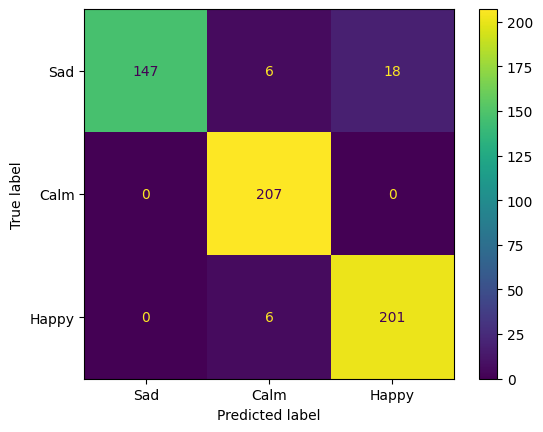

In [86]:
# Make predictions on the test set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



# Print classification report
print(classification_report(y_test, train_predictions_labels, labels=[0, 1,2]))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, train_predictions_labels), display_labels=["Sad", "Calm", "Happy"])
disp.plot()
plt.savefig(f"../Figure/Son_ANN")
plt.show()


In [77]:
import pickle
pickle.dump(model, open("../trained_model/ANN.h5", "wb"))

# pickle.dump(model, open("/Users/nguyentrithanh/Downloads/OneDrive_1_29-5-2024/ZZZZZ/trained_model/ANN.h5", "wb"))
